In [223]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

### Explore the Data - Univariate and Bi-variates

Univariate checks:
1. The sample size (1372 rows, four features), and the balance of target (44.5% banknotes are fake).
2. Features include: variance, skewness, and Kurtosis of the wavelets, and entropy.
   Target for classification is whether the banknote is fake or authentic (where fake = 1).
3. Check if each variable in the data has missing values (no missing).
4. The descriptive statistics for each variable to compare the distributions - a base to decide whether scale is necessary.
5. Distribution of each variable - base for us to know whether we need to transform data and to choose the right models.

Bi-variates:
1. We want to explore visually which features will help or not help in classifying the fake banknotes.
2. Histograms, Box-plots, and Pair Plots will be used to explore feature relationships with each other and with target.
3. Correlations will tell us whether we need to ajust for multcolinearity issues (such as using Ridge - L2 regulations).

In [214]:
# Read in data, check sample size
column_names =["varianceW", "skewnessW","kurtosisW", "entropy", "fake"]
dat = pd.read_csv("data_banknote_authentication.txt", sep=",", header=None )
dat.columns = column_names
dat.shape # 1372 rows by 5 columns
dat.head()


,varianceW,skewnessW,kurtosisW,entropy,fake
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [156]:
# Check each variable type - all are numerics.
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
varianceW    1372 non-null float64
skewnessW    1372 non-null float64
kurtosisW    1372 non-null float64
entropy      1372 non-null float64
fake         1372 non-null int64
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [157]:
 # Check if there is missing values - no missing values.
dat.isnull().sum() 

varianceW    0
skewnessW    0
kurtosisW    0
entropy      0
fake         0
dtype: int64

In [158]:
# Check how balanced the target 
dat.groupby('fake').count()
# 610 fake vs. 762 authentic, pretty balanced 44.5% are fake.

,varianceW,skewnessW,kurtosisW,entropy
fake,,,,
0,762,762,762,762
1,610,610,610,610


In [159]:
# Check descriptive statistics: data not scaled, and the features were not measured in similar scales
dat.describe() 

,varianceW,skewnessW,kurtosisW,entropy,fake
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [160]:
# Looking at the feature descriptives by the authenticity of banknotes
dat[dat['fake']==1].describe()

,varianceW,skewnessW,kurtosisW,entropy,fake
count,610.000000,610.000000,610.000000,610.000000,610.0
mean,-1.868443,-0.993576,2.148271,-1.246641,1.0
std,1.881183,5.404884,5.261811,2.070984,0.0
min,-7.042100,-13.773100,-5.286100,-7.588700,1.0
25%,-3.061450,-5.810025,-1.357500,-2.458375,1.0
50%,-1.806100,0.172775,0.373720,-0.661650,1.0
75%,-0.541770,3.189275,5.626350,0.341790,1.0
max,2.391700,9.601400,17.927400,2.135300,1.0


In [161]:
dat[dat['fake']==0].describe()

,varianceW,skewnessW,kurtosisW,entropy,fake
count,762.000000,762.000000,762.000000,762.000000,762.0
mean,2.276686,4.256627,0.796718,-1.147640,0.0
std,2.019348,5.138792,3.239894,2.125077,0.0
min,-4.285900,-6.932100,-4.941700,-8.548200,0.0
25%,0.883345,0.450063,-1.709700,-2.228250,0.0
50%,2.553100,5.668800,0.700605,-0.552380,0.0
75%,3.884450,8.691975,2.652925,0.423258,0.0
max,6.824800,12.951600,8.829400,2.449500,0.0


'fake'

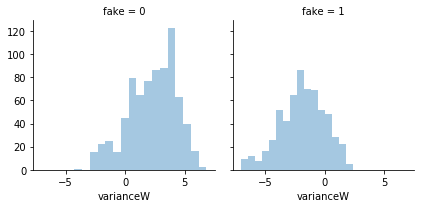

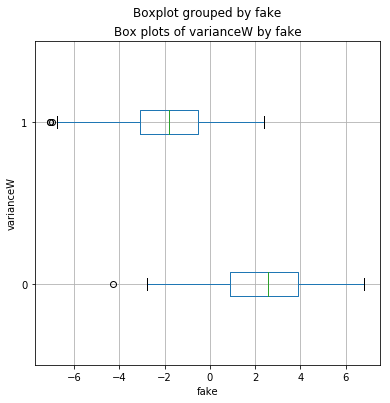

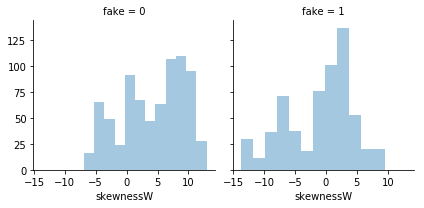

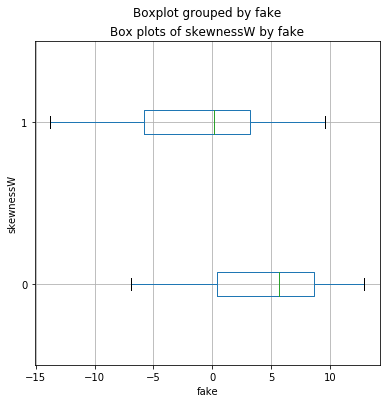

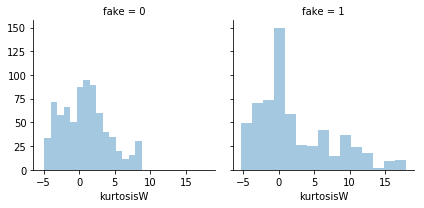

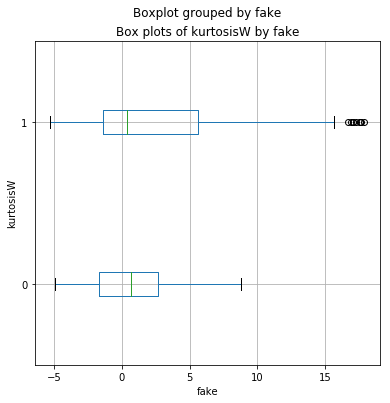

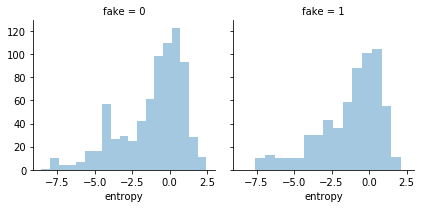

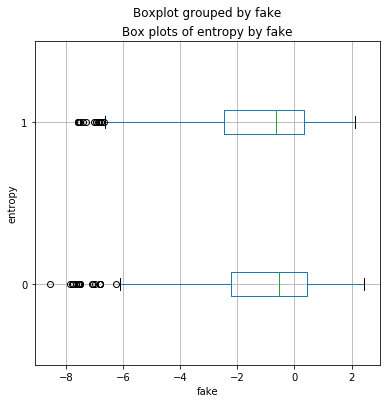

In [162]:
## Let's look at how features are distributed by the authenticity of banknotes
def cond_distplot(df, plot_cols, grid_col, by):
    import matplotlib.pyplot as plt
    import seaborn as sns
    ## Loop over the list of columns
    for col in plot_cols:
        grid1 = sns.FacetGrid(df, col=grid_col)
        grid1.map(sns.distplot, col,  kde=False)
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
        df.boxplot(column = col, by = by, ax = ax,vert=False)
        ax.set_title('Box plots of ' + col + ' by ' + by)
        ax.set_ylabel(col)
    return grid_col

## Define columns for making a conditioned histogram
plot_col = ["varianceW", "skewnessW","kurtosisW", "entropy"]

cond_distplot(dat, plot_col, 'fake', 'fake')

From the above histograms we can see that "kurtosisW"" skews to the right and "entropy"" skews to the left.
And all four features are not quite normally distributed, however curtosisW and entropy are more obviousely skewed.
And therefore, when we think of what algorithms to apply for the classification, we need to think of model assumptions.  For example Naive Bayes assumes normal distribution, we can use this information to decide whether to use NB or not.  And if we decide to use NB, how to transform the features so that they are more normally distributed. 

From the box plots, we can see that the varianceW separates fake vs. authenticity the best, while 'entropy' is the worst.  And 'skewnessW' separates better while 'curtosisW' is not good.

The following pairplots make it clear that variance and skewness of wavelets, and the relationship of varianceW with Kurtosis, entropy will help to separate fake and authenticate banknotes.


<function matplotlib.pyplot.show>

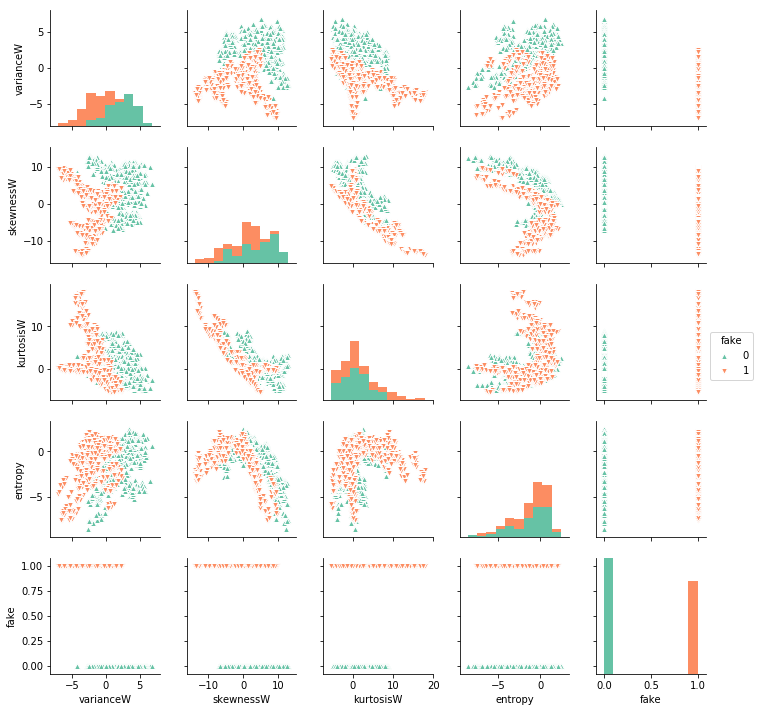

In [163]:
sns.pairplot(dat, hue='fake', size=2.0, palette="Set2",  markers=["^", "v"])
plt.show

In [164]:
dat.corr()


,varianceW,skewnessW,kurtosisW,entropy,fake
varianceW,1.000000,0.264026,-0.380850,0.276817,-0.724843
skewnessW,0.264026,1.000000,-0.786895,-0.526321,-0.444688
kurtosisW,-0.380850,-0.786895,1.000000,0.318841,0.155883
entropy,0.276817,-0.526321,0.318841,1.000000,-0.023424
fake,-0.724843,-0.444688,0.155883,-0.023424,1.000000


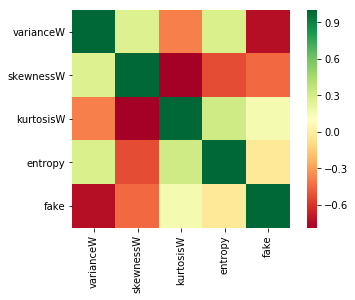

In [185]:
sns.heatmap(dat.corr(), square=True, cmap='RdYlGn')

We can see here is that skewness of wavelets is highly correlated with kurtosis of wavelets (negatively at 0.79), and is moderately corrected to entropy (negative 0.53).  The correlations among variance, kurtosis and entropy of wavelets are <0.4.

Because Naive Bayes assumes independence, I suspect that NB will perform worse than other algorithms and I will test this later.


### Classification Algorithms

1. Identify performance measures based on the question at hand:
   In this case of predicting fake banknotes, I think that accuracy is important, but at the same time the sensitivity and    specificity are equally important.  Because failing to predict when the banknote is fake (sensitivity where we included fake notes as real mondy) is as costy as when we identified authentic notes as fake notes (specificity).
   So the measures to test algorithm perfomance will include:
   (1) Accuracy = (True Positive + True Negative)/total
   (2) Sensitivity = True Positive / (True Positive + False Negtive)
   (3) Specificity = True Negative / (True Negative + False Positive)
   (4) Error = 1 - Accuracy
  
2. I will leave randomly chosen 30% of the data as final test data.

3. And I will use 10-fold cross-validation with 70% of the data and Errors, to test the performance of Logistic Regression Classifier, DecisionTreeClassifier,  BernoulliNB, KNeighborsClassifier, SVM, and Random Forest Classifier. 
And I can predict now that based on the above EDA, the SVM will perform the best because the default kernel for SVM is radial, which will take care of the need of higher-dimention of the features.  And I anticipate that NB will perform the worst, because from the histograms above we can see that the features are not quite normally distributed especially 'entropy' and 'kurtosisW'.  And the features are not independent because we see that Skewness is correlated with entropy and kurtosis.

4. Explore the potentials for feature engineering, and hypter-parameter testing to improve algorithms performances.



In [215]:
X = dat.drop('fake', axis=1)
y = dat['fake']

In [262]:
# Standardize the features
sc = StandardScaler()
sc.fit(X)
scaled_X = sc.transform(X)
sX = pd.DataFrame(scaled_X, columns = X.columns)


In [263]:
X_train, X_test, y_train, y_test = train_test_split(sX, y, test_size=0.30, random_state=5, stratify=y)
X_train.head()

,varianceW,skewnessW,kurtosisW,entropy
1316,-0.716689,-0.393970,0.051613,1.476948
1052,-1.004156,-0.369280,-0.161581,0.766456
1044,-0.677101,-0.705764,0.048224,0.993024
275,1.054804,0.739972,-0.777291,0.395195
889,-0.612422,-0.284633,-0.147460,1.412908


In [224]:
scoring = "accuracy"
seed = 123
# Comparing models
models = []

models.append(('LR', LogisticRegression()))
models.append(('Dtree', DecisionTreeClassifier()))
models.append(('NB', BernoulliNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('rfc', RandomForestClassifier()))



#we iterate through all models and test their performance measured by 1 - accuracy = error
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = 1- model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
results
names

LR: 0.020833 (0.014731)
Dtree: 0.020833 (0.013176)
NB: 0.153125 (0.035493)
KNN: 0.003125 (0.004774)
SVM: 0.000000 (0.000000)
rfc: 0.007292 (0.004774)


['LR', 'Dtree', 'NB', 'KNN', 'SVM', 'rfc']

In [264]:
errs = pd.DataFrame(results)
allerrs = errs.T
allerrs.columns = ['LR', "Dtree", 'NB', 'KNN', 'SVM','rfc']


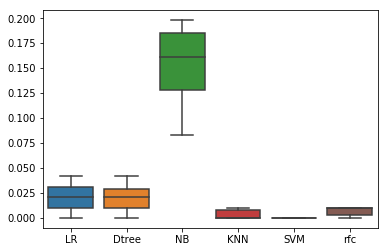

In [267]:
#sns.boxplot(allerrs)
import warnings
warnings.filterwarnings("ignore")
sns.boxplot(data=allerrs.ix[:,0:6])


In [110]:
# Now let's train the SVM with all the training data and use it on the test data
svm = SVC().fit(X_train, y_train)
svm_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, svm_pred)
print('Confusion Matrix : \n', cm)
total = sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity )
error = 1 - accuracy
print('Error : ', error )

Confusion Matrix : 
 [[229   0]
 [  0 183]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Error :  0.0


### SVM is the best.  But can we improve Logistic Regression by Regularization and Feature Engineering?

We know that "logistic regression requires the observations to be independent of each other.  In other words, the observations should not come from repeated measurements or matched data."

And, "logistic regression requires there to be little or no multicollinearity among the independent variables.  This means that the independent variables should not be too highly correlated with each other." (citation 3)

1. One way to take care of multicollinearity is to use Ridge Regulation - it turns out that Sklearn Logistic Regression, the default penalty is Ridge or l2 regulation.
2. We can also use Lasso l1 regularizition to select out unnecessary features.
3. We can create polynomials including interactions to take away the multicollinearity and to consider non-linear relationship between target and certain features.

In [116]:
# The default is l2
LR = LogisticRegression(penalty='l2').fit(X_train, y_train)
LR_pred = LR.predict(X_test)
cm = confusion_matrix(y_test, LR_pred)
print('Confusion Matrix : \n', cm)
total = sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity )
error = 1 - accuracy
print('Error : ', error )

Confusion Matrix : 
 [[224   5]
 [  0 183]]
Accuracy :  0.9878640776699029
Sensitivity :  0.9781659388646288
Specificity :  1.0
Error :  0.012135922330097082


In [115]:
LR = LogisticRegression(penalty='l1').fit(X_train, y_train)
LR_pred = LR.predict(X_test)
cm = confusion_matrix(y_test, LR_pred)
print('Confusion Matrix : \n', cm)
total = sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity )
error = 1 - accuracy
print('Error : ', error )

Confusion Matrix : 
 [[227   2]
 [  0 183]]
Accuracy :  0.9951456310679612
Sensitivity :  0.9912663755458515
Specificity :  1.0
Error :  0.004854368932038833


In [119]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
Xtrain_poly = poly.fit_transform(X_train)
Xtest_poly = poly.fit_transform(X_test)

LRP = LogisticRegression(penalty='l1').fit(Xtrain_poly, y_train)
LRP_pred = LRP.predict(Xtest_poly)

cm = confusion_matrix(y_test, LRP_pred)
print('Confusion Matrix : \n', cm)
total = sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity )
error = 1 - accuracy
print('Error : ', error )

Confusion Matrix : 
 [[229   0]
 [  0 183]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Error :  0.0


### And we achieved 100% on all performance measures for Logistic Regression - as good as SVM!

In [286]:
Dtree=DecisionTreeClassifier(random_state=6).fit(X_train, y_train)
Dtree_pred = Dtree.predict(X_test)
cm = confusion_matrix(y_test, Dtree_pred)
print('Confusion Matrix : \n', cm)
total = sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity )
error = 1 - accuracy
print('Error : ', error )

Confusion Matrix : 
 [[227   2]
 [  3 180]]
Accuracy :  0.9878640776699029
Sensitivity :  0.9912663755458515
Specificity :  0.9836065573770492
Error :  0.012135922330097082


In [283]:
from sklearn.grid_search import GridSearchCV
#from sklearn.metrics import make_scorer
#from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
params = {"max_depth": [1,3,5,7,9,11, 13, 15, 20], "max_features":['auto', 'sqrt', 'log2'], "random_state":[6]}
classifier = DecisionTreeClassifier()
CV_tree = GridSearchCV(estimator=classifier, param_grid=params, cv=10, scoring= 'accuracy')
CV_tree.fit(X_train, y_train)
print(CV_tree.best_params_)

{'max_depth': 9, 'max_features': 'auto', 'random_state': 6}


In [285]:
Dtree2=DecisionTreeClassifier(max_depth=9, max_features='auto', random_state=6).fit(X_train, y_train)
Dtree_pred2 = Dtree2.predict(X_test)
cm = confusion_matrix(y_test, Dtree_pred2)
print('Confusion Matrix : \n', cm)
total = sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity )
error = 1 - accuracy
print('Error : ', error )

Confusion Matrix : 
 [[226   3]
 [  1 182]]
Accuracy :  0.9902912621359223
Sensitivity :  0.9868995633187773
Specificity :  0.994535519125683
Error :  0.009708737864077666


#### By tunning the hyper-paramethers, we only lowered the error rate from Dtree slightly (from 0.012 to 0.0097).
But considering that we only tried one random state, the difference is small. In other situations, the potential of
improvement might be more.

### Now let's see if we can improve NB performance.

Since NB assumes that the features are inpendent, I will try to delete the entropy and kurtosisW that are highly correlated with skewnessW.  And from the EDA, we see that there may have interaction between variance and skewness of wavelets, so I created an interaction term to include as a new feature.

In [276]:
# Now for the Naive Bayes again. 
sXX = sX.drop(['kurtosisW', 'entropy'], axis=1)
sXX['Interaction'] = sXX['varianceW']*sXX['skewnessW']
X_train1, X_test1, y_train1, y_test1 = train_test_split(sXX, y, test_size=0.30, random_state=5, stratify=y)
sXX.head()

,varianceW,skewnessW,Interaction
0,1.121806,1.149455,1.289465
1,1.447066,1.064453,1.540333
2,1.207810,-0.777352,-0.938893
3,1.063742,1.295478,1.378054
4,-0.036772,-1.087038,0.039972


In [244]:
NB = BernoulliNB().fit(X_train1, y_train1)
NB_pred = NB.predict(X_test1)
cm = confusion_matrix(y_test1, NB_pred)
print('Confusion Matrix : \n', cm)
total = sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity )
error = 1 - accuracy
print('Error : ', error )

Confusion Matrix : 
 [[199  30]
 [ 23 160]]
Accuracy :  0.8713592233009708
Sensitivity :  0.868995633187773
Specificity :  0.8743169398907104
Error :  0.12864077669902918


In [287]:
# The original model performance:
NB = BernoulliNB().fit(X_train, y_train)
NB_pred = NB.predict(X_test)
cm = confusion_matrix(y_test, NB_pred)
print('Confusion Matrix : \n', cm)
total = sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print ('Accuracy : ', accuracy)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity )
error = 1 - accuracy
print('Error : ', error )

Confusion Matrix : 
 [[187  42]
 [ 23 160]]
Accuracy :  0.8422330097087378
Sensitivity :  0.8165938864628821
Specificity :  0.8743169398907104
Error :  0.15776699029126218


#### We can see that comparing with the original performances (with all four features and no interaction term), 
#### the new model has improved about 3% in accuracy and lowered 3% in error rate.  The improvement happened more on the sensitivity.

### In conclusion, this is an exercise for me to learn to understand how to improve model performances.  Even if when ML algorithms
### are automatic and powerful, I think there will have a lot situations that will require that we understand the data and 
### the assumptions of each algorithm so that we can improve predications by feature engineering, hyper-paramether tuning, 
### model selection and maybe all of the above.  Thank you.

#### Data and Juypter Notebook can be downloaded here:
https://github.com/zhongheli/Python_E29